0.提取词云

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install python-docx wordcloud matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 5.9 MB/s eta 0:00:00


Processing /content/drive/My Drive/Work/1.高中生情感分类/doc/高中生数学学习情况调查.docx...
Processing /content/drive/My Drive/Work/1.高中生情感分类/doc/高中生睡眠时间问卷调查.docx...
Processing /content/drive/My Drive/Work/1.高中生情感分类/doc/高中生学习压力问卷调查.docx...
Processing /content/drive/My Drive/Work/1.高中生情感分类/doc/高中生学习规划问卷调查.docx...
Processing /content/drive/My Drive/Work/1.高中生情感分类/doc/高中生饮食情况问卷调查.docx...
Processing /content/drive/My Drive/Work/1.高中生情感分类/doc/高中生运动锻炼情况问卷调查.docx...
Processing /content/drive/My Drive/Work/1.高中生情感分类/doc/高中生心理情感状况问卷调查.docx...


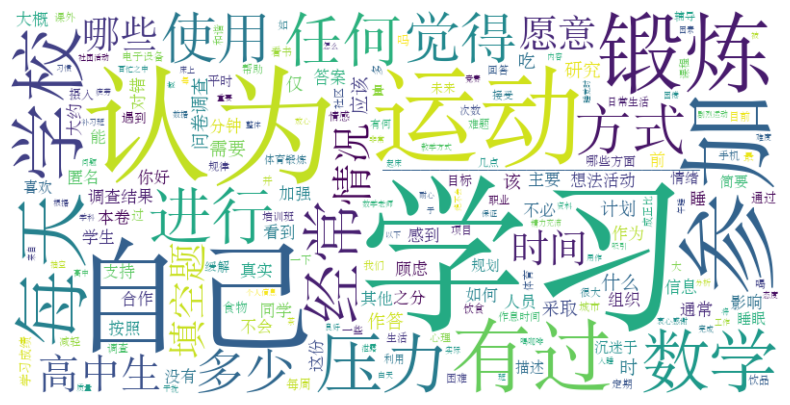

In [10]:
import os
from docx import Document
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba

import jieba

# 定义停用词列表
stopwords = set([
    '的', '你', '我', '他', '在', '是', '有', '和', '就',
    '不', '人', '都', '一', '一个', '上', '也', '很', '到',
    '说', '要', '以', '和', '了', '下', '去', '之', '会',
    '可以', '这', '而', '及', '了', '对', '着', '或', '中',
    '与', '等', '及', '单选题', '多选题', '填空', '是否', '多选',
    '单选', '问卷', '填写', '您', '可多选', '请', '非常感谢'

])

def chinese_word_segmentation(text):
    """ 对中文文本进行分词并过滤停用词 """
    wordlist = jieba.cut(text, cut_all=False)
    return ' '.join(word for word in wordlist if word not in stopwords)


def extract_text_from_docx(docx_path):
    """ 从.docx文件中提取文本内容 """
    document = Document(docx_path)
    text = [paragraph.text for paragraph in document.paragraphs if paragraph.text]
    return "\n".join(text)


def generate_wordcloud(text, font_path=None):
    """ 根据提供的文本生成词云，并显示 """
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        font_path=font_path,  # 使用支持中文的字体
        collocations=False,    # 不统计搭配词频
        ).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def process_all_docx(directory, font_path=None):
    """ 处理指定目录下的所有.docx文件 """
    combined_text = ""
    for filename in os.listdir(directory):
        if filename.endswith(".docx"):
            file_path = os.path.join(directory, filename)
            print(f"Processing {file_path}...")
            doc_text = extract_text_from_docx(file_path)
            combined_text += chinese_word_segmentation(doc_text) + "\n"

    if combined_text:
        generate_wordcloud(combined_text, font_path)
    else:
        print("No .docx files found or they are empty.")



# 指定包含.docx文件的目录
directory = '/content/drive/My Drive/Work/1.高中生情感分类/doc'
# 指定支持中文的字体路径
font_path = '/content/drive/My Drive/Work/1.高中生情感分类/doc/经典宋体简.ttf'

process_all_docx(directory, font_path=font_path)


1.数据加载和合并

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import jieba

# 加载数据
def load_data(file_path):
    return pd.read_csv(file_path, header=None, names=['text'],on_bad_lines='skip')

negative_words_ts = load_data('/content/drive/My Drive/Work/1.高中生情感分类/negative_words.csv')
neutral_words_ts = load_data('/content/drive/My Drive/Work/1.高中生情感分类/neutral_words.csv')
positive_words_ts = load_data('/content/drive/My Drive/Work/1.高中生情感分类/positive_words.csv')


# 分配标签
neutral_words_ts['label'] = 0
positive_words_ts['label'] = 1
negative_words_ts['label'] = 2

# 合并数据集
data_ts = pd.concat([positive_words_ts, neutral_words_ts, negative_words_ts])

In [ ]:
data_ts

,text,label
0,除了授课和答疑，我非常希望在课余时间有机会和老师交流。,1
1,我认为面对学习生活中的压力，要化压力为动力。,1
2,我会通过与家人朋友聊天，宣泄自己的压力。,1
3,我会通过读书、听音乐宣泄自己的压力。,1
4,我比较反感身边同学吸烟，吸烟会危害自己以及身边同学的身心健康。,1
...,...,...
569,“我真的好想回到过去，重新选择一条不同的路。”,2
570,“我觉得自己好像被困在了这个循环里，每天都过得一模一样。”,2
571,“每次想到自己的未来，我就会觉得特别迷茫。”,2
572,“我觉得没人能够理解我，我真的好想有人能理解我，支持我去追求自己的梦想。”,2


In [ ]:
#随机化数据
data_ts = data_ts.sample(frac=1).reset_index(drop=True)

import requests

stop_words_url = 'https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt'

# 使用requests库下载停用词库
response = requests.get(stop_words_url)
stop_words = set(response.text.splitlines())

def preprocess_chinese_text(text):
    # 使用jieba进行中文分词
    words = jieba.cut(text)
    # 移除停用词
    filtered_words = [word for word in words if word not in stop_words and not word.isspace()]
    # 合并词汇为一个字符串
    return ' '.join(filtered_words)

# 应用预处理函数到文本列
data_ts['original_text'] = data_ts['text'].copy()
data_ts['text'] = data_ts['text'].apply(preprocess_chinese_text)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 3.236 seconds.
DEBUG:jieba:Loading model cost 3.236 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
from gensim.models import KeyedVectors

# 划分数据集
X = data_ts['text']
y = data_ts['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# 文本序列化和填充
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
max_seq_length = 100
X_pad = pad_sequences(X_seq, maxlen=max_seq_length)

# 加载腾讯的预训练模型
model_path = '/content/drive/My Drive/Work/1.高中生情感分类/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt'
word_vectors_zh = KeyedVectors.load_word2vec_format(model_path, binary=False)

In [ ]:
# 初始化词嵌入矩阵
embedding_dim = 100  # 根据实际词向量的维度进行设置
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = word_vectors_zh[word] if word in word_vectors_zh else None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, SimpleRNN, GlobalMaxPooling1D, Embedding, Dropout, Dense

CNN

L2正则化

In [ ]:
from tensorflow.keras.regularizers import l2

def build_cnn_model(input_dim, output_dim, input_length, embedding_matrix):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=input_length, trainable=False),
        Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),  # 添加L2正则化
        GlobalMaxPooling1D(),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=100, embedding_matrix=embedding_matrix)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_categorical, test_size=0.2, random_state=42)

模型训练和性能对比

In [ ]:
# CNN模型训练
history_cnn = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)
print(cnn_model.summary())

Epoch 1/10
21/21 [==============================] - 4s 96ms/step - loss: 2.3867 - accuracy: 0.5966 - val_loss: 1.9881 - val_accuracy: 0.7976
Epoch 2/10
21/21 [==============================] - 1s 46ms/step - loss: 1.7287 - accuracy: 0.8494 - val_loss: 1.5561 - val_accuracy: 0.8482
Epoch 3/10
21/21 [==============================] - 1s 42ms/step - loss: 1.3544 - accuracy: 0.9038 - val_loss: 1.3045 - val_accuracy: 0.8690
Epoch 4/10
21/21 [==============================] - 1s 45ms/step - loss: 1.1136 - accuracy: 0.9374 - val_loss: 1.1300 - val_accuracy: 0.8869
Epoch 5/10
21/21 [==============================] - 1s 45ms/step - loss: 0.9370 - accuracy: 0.9560 - val_loss: 1.0127 - val_accuracy: 0.8929
Epoch 6/10
21/21 [==============================] - 1s 45ms/step - loss: 0.8208 - accuracy: 0.9664 - val_loss: 0.9154 - val_accuracy: 0.8810
Epoch 7/10
21/21 [==============================] - 1s 41ms/step - loss: 0.7172 - accuracy: 0.9724 - val_loss: 0.8321 - val_accuracy: 0.8810
Epoch 8/10
21

In [ ]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

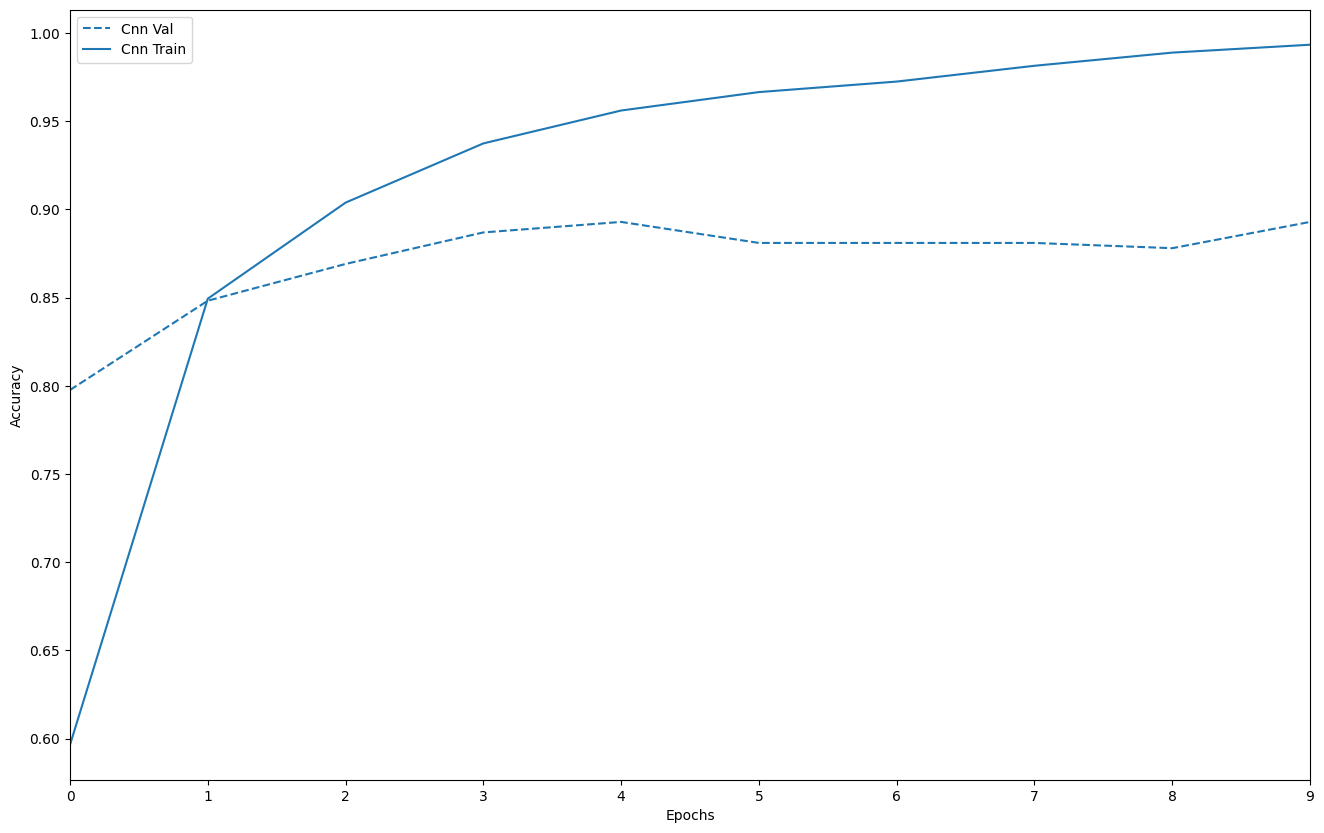

In [ ]:
# 绘制模型性能
plot_history([('cnn', history_cnn)], key='accuracy')

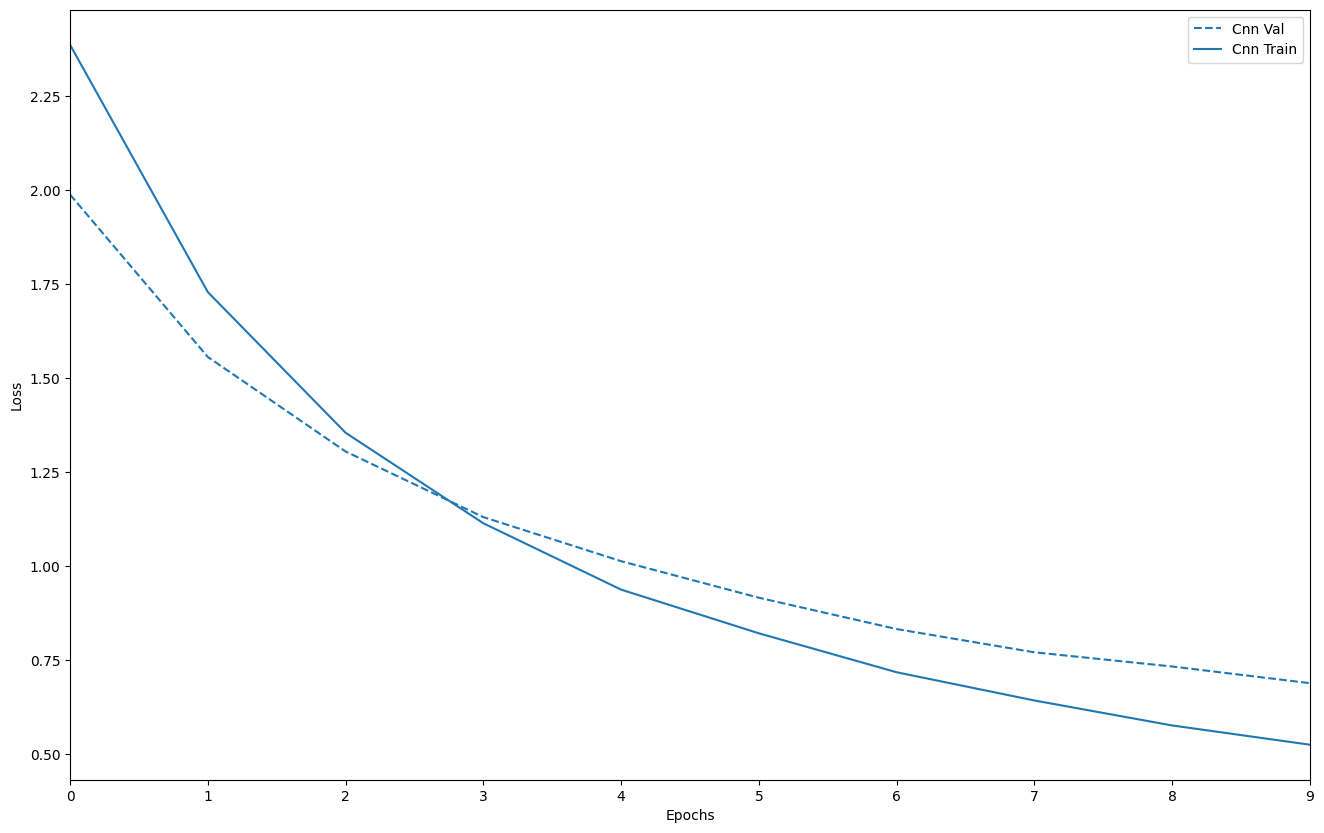

In [ ]:
plot_history([('cnn', history_cnn)], key='loss')

性能对比

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np

# 计算每个模型的性能指标
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='macro')
    return accuracy, f1, recall

metrics_cnn = evaluate_model(cnn_model, X_test, y_test)



11/11 [==============================] - 0s 15ms/step


In [ ]:
# 绘制性能对比图
metrics = np.array([metrics_cnn])
metrics_df = pd.DataFrame(metrics, index=['CNN'], columns=['Accuracy', 'F1 Score', 'Recall'])

In [ ]:
print(metrics_df)

     Accuracy  F1 Score    Recall
CNN  0.892857  0.892204  0.890332


# **训练过程**

In [ ]:
!pip install ipywidgets
from ipywidgets import widgets, Layout
from IPython.display import display
from sklearn.metrics import accuracy_score, recall_score, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# 定义绘制模型性能图表的函数
def plot_model_performance(history, title):
    clear_output(wait=True)  # 清除之前的输出
    plt.figure(figsize=(12, 4))

    # 绘制训练 & 验证的准确率值
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy - {title}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # 绘制训练 & 验证的损失值
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss - {title}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

# 为每个模型创建一个查询按钮，并绑定事件
def create_query_button(model_name, history):
    button = widgets.Button(description=f"Query {model_name} Model",
                            layout=widgets.Layout(width='200px'))
    def on_button_clicked(b):
        with output:
            plot_model_performance(history, model_name)

    button.on_click(on_button_clicked)
    display(button)

# 输出区域
output = widgets.Output()

# 显示所有按钮和输出区域
create_query_button('CNN', history_cnn)
display(output)


Button(description='Query CNN Model', layout=Layout(width='200px'), style=ButtonStyle())

Output()

# **文本查询**

In [ ]:
output_area2 = widgets.Output()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [ ]:
# 模型预测函数
def predict_with_model(model, X):
    predictions = model.predict(X)
    return np.argmax(predictions, axis=1)

In [ ]:
# 查询并显示结果的函数
def display_statements(model, emotion, num_statements, data_ts):
    predicted_classes = predict_with_model(model, X_test)
    # 将用户选择的情感转换为对应的整数标签
    emotion_to_label = {'积极': 1, '中立': 0, '消极': 2}
    label = emotion_to_label[emotion]

    # 获取对应情感预测的索引
    selected_indices = np.where(predicted_classes == label)[0]

    # 如果用户指定的数量超过了找到的文本数量，调整为实际数量
    num_statements = min(num_statements, len(selected_indices))

    # 随机选择指定数量的索引
    if num_statements > 0:
        selected_samples = np.random.choice(selected_indices, num_statements, replace=False)
    else:
        selected_samples = []

    # 显示这些文本
    for idx in selected_samples:
        print(data_ts.iloc[idx]['original_text'])  # 确保你有一个保存原始文本的列，这里使用了'text'


def display_performance(model, emotion):
    # 根据selected_emotion筛选对应情感的文本和标签
    emotion_to_label = {'积极': 1, '中立': 0, '消极': 2}
    label = emotion_to_label[emotion]
    indices = np.where(y == label)[0]
    selected_X_test = X_pad[indices]
    selected_y_test = y_categorical[indices]

    # 预测
    predictions = model.predict(selected_X_test)
    predictions = np.argmax(predictions, axis=1)

    # 计算性能指标
    accuracy = accuracy_score(np.argmax(selected_y_test, axis=1), predictions)
    recall = recall_score(np.argmax(selected_y_test, axis=1), predictions, average='macro', zero_division=1)
    f1 = f1_score(np.argmax(selected_y_test, axis=1), predictions, average='macro',zero_division=1)

    # 显示性能指标
    print(f"准确率: {accuracy:.2f}")
    print(f"召回率: {recall:.2f}")
    print(f"F1得分: {f1:.2f}")



In [ ]:
query_button = widgets.Button(
    description='查询',
    button_style='success',
)


# 按钮点击事件处理函数
def on_query_button_clicked(b):
    with output_area2:
      output_area2.clear_output(wait=True)  # 清除输出区域的内容
      selected_model = model_dropdown.value
      emotion = emotion_dropdown.value
      num_statements = num_statements_input.value

      # 根据选择的模型调用相应的函数
      if selected_model == 'CNN':
        model = cnn_model


      display_statements(model, emotion, num_statements, data_ts) #显示语句
      display_performance(model, emotion)  # 显示性能指标


query_button.on_click(on_query_button_clicked)

In [ ]:
# 创建情感类别下拉菜单
emotion_dropdown = widgets.Dropdown(
    options=['积极', '中立', '消极'],
    value='积极',
    description='情感类别:',
)

# 创建UI组件
model_dropdown = widgets.Dropdown(
    options=['CNN'],
    value='CNN',
    description='模型:',
)

num_statements_input = widgets.IntText(
    value=5,
    description='语句数量:',
    disabled=False
)

# 当情感类型或语句数量改变时触发的函数
def on_value_change(change):
    emotion = emotion_dropdown.value
    num_statements = num_statements_input.value
    model = model_dropdown.value

# 监听下拉菜单和整数输入框的变化
emotion_dropdown.observe(on_value_change, names='value')
model_dropdown.observe(on_value_change, names='value')
num_statements_input.observe(on_value_change, names='value')

output_area2.clear_output()

# 组合UI组件并显示
ui = widgets.VBox([model_dropdown, emotion_dropdown, num_statements_input, query_button, output_area2])
display(ui)